### References/Credits: Animikh Aich - https://github.com/animikhaich

## Algorithm structure:
### The class CNNClassifier has methods like: 
### 1. init_model() which initializes the deep learning model with all the important layers and weights.
### 2. load_data() pre-processes the data and returns the images which are ready as the inputs to the model.
### 3. train() which trains the model with the set number of learning rate, epochs and callbacks.
### 4. predict() which loads the trained model and then predicts with the test input accordingly.

## ResNet50 Classifier with Fingervein recognition data

2022-11-30 17:45:11.355837: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-30 17:45:11.355889: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/homebrew/Caskroom/miniforge/base/envs/mlp1/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20


2022-11-30 17:45:24.354174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - ETA: 0s - loss: 3.9714 - accuracy: 0.1419

2022-11-30 17:48:37.698539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - 211s 1s/step - loss: 3.9714 - accuracy: 0.1419 - val_loss: 5.0807 - val_accuracy: 0.0013 - lr: 1.0000e-04
Epoch 2/20
191/191 [==============================] - 204s 1s/step - loss: 1.5646 - accuracy: 0.5806 - val_loss: 6.9471 - val_accuracy: 0.0092 - lr: 1.0000e-04
Epoch 3/20
191/191 [==============================] - 205s 1s/step - loss: 0.4836 - accuracy: 0.8604 - val_loss: 5.4960 - val_accuracy: 0.0065 - lr: 1.0000e-04
Epoch 4/20
191/191 [==============================] - 203s 1s/step - loss: 0.2112 - accuracy: 0.9387 - val_loss: 6.7436 - val_accuracy: 0.0131 - lr: 1.0000e-04
Epoch 5/20
191/191 [==============================] - 203s 1s/step - loss: 0.1096 - accuracy: 0.9653 - val_loss: 5.0000 - val_accuracy: 0.0550 - lr: 1.0000e-04
Epoch 6/20
191/191 [==============================] - 205s 1s/step - loss: 0.1111 - accuracy: 0.9649 - val_loss: 3.4407 - val_accuracy: 0.2657 - lr: 1.0000e-04
Epoch 7/20
191/191 [==============================]

INFO:tensorflow:Assets written to: ram://3608e55d-1f27-4d89-92ec-63197c290c06/assets


INFO:tensorflow:Assets written to: ram://3608e55d-1f27-4d89-92ec-63197c290c06/assets
2022-11-30 19:25:31.311662: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-30 19:25:31.318805: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


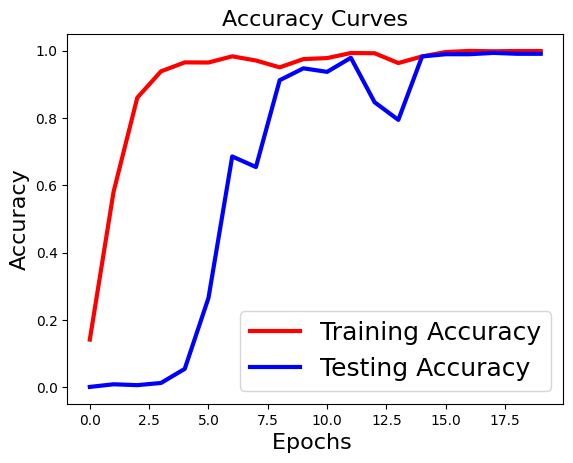

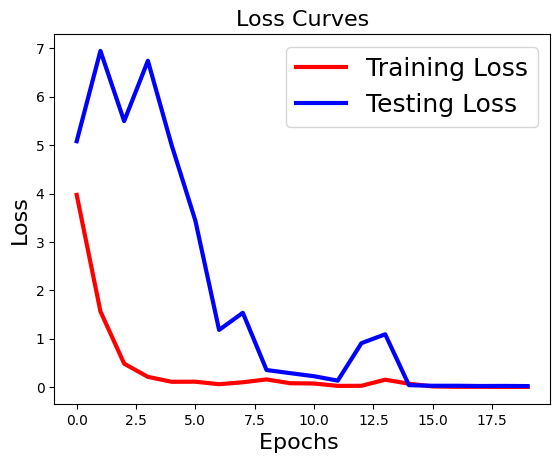

2022-11-30 19:25:47.577524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 14s 530ms/step


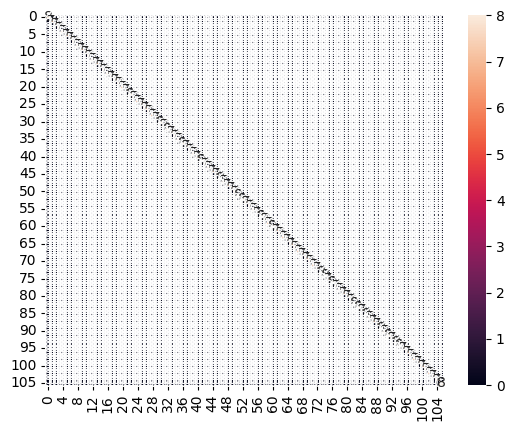

In [7]:
import tensorflow as tf
import numpy as np
import keras
#from tensorflow.python.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.backend import set_session
import cv2, os, gc
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pickle

class CNNClassifier:

    def __init__(self, shape=None, enableGPUTraining=True):
        if shape is None:
            self.resize = False
            self.imshape = (240, 320, 3)
        else:
            self.resize = True
            self.imshape = shape

        self.model = None
        self.x = list()
        self.y = list()
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.preds = None

        if enableGPUTraining:
            config = tf.compat.v1.ConfigProto()
            config.gpu_options.allow_growth = True
            config.log_device_placement = False
            sess = tf.compat.v1.Session(config=config)
            set_session(sess)
        else:
            os.environ["CUDA_VISIBLE_DEVICES"] = ""
   
    def init_model(self, num_classes):
       
        self.num_classes = num_classes
        #base = Xception(include_top=False, weights='imagenet', input_shape=self.imshape)
        base = ResNet50(include_top=False, weights='imagenet', input_shape=self.imshape)
        for layer in base.layers[:5]:
            layer.trainable = False

        x = base.output
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(250, activation='relu')(x)
        x = keras.layers.Dropout(0.25)(x)
        preds = keras.layers.Dense(num_classes, activation='softmax', name='fcFinal')(x)

        self.model = keras.models.Model(base.input,preds)
        for layer in self.model.layers:
            layer.trainable = True
       
        return self.model

    def load_data(self, root_path, test_set_percent=0.20, limitedMemory=True):
        folder_names = sorted(os.listdir(root_path))
        for folder in folder_names:
            left = glob(os.path.join(root_path, folder, 'left', '*'))
            right = glob(os.path.join(root_path, folder, 'right', '*'))
            imPaths = left + right
            imPaths = [path for path in imPaths if '.bmp' in path]

            for imPath in imPaths:
                image = cv2.imread(imPath)
                if self.resize:
                    image = cv2.resize(image, self.imshape[:2], cv2.INTER_AREA)
                self.x.append(image)
                self.y.append(int(folder))

        self.y = keras.utils.np_utils.to_categorical(self.y)
        self.x = np.asarray(self.x)

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=test_set_percent, stratify=self.y)

        self.X_train = (self.X_train / 255.).astype(np.float16)
        self.X_test = (self.X_test / 255.).astype(np.float16)

        return self.X_train, self.X_test, self.y_train, self.y_test

    def train(self, lr=0.001, epoch=20, batch_size=64, weights_path='./weights/'):

        if not os.path.exists(weights_path):
            os.makedirs(weights_path)

        callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_path, 'weights.h5'), \
            monitor='val_accuracy', verbose=0, save_weights_only=True, save_best_only=True)
        callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, verbose=1)
        callback_reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_lr=1e-7, patience=2, verbose=1)
        callbacks = [callback_checkpoint, callback_early_stopping, callback_reduce_lr]

        opt = tf.keras.optimizers.Adam(lr=lr)
        self.model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        history = self.model.fit(x=self.X_train, y=self.y_train, epochs=epoch, batch_size=batch_size, validation_data=(self.X_test, self.y_test), callbacks=callbacks)

        return self.model, history

    def predict(self, X=None, y=None, weights_path='./weights/'):

        if X is None and y is None:
            X = self.X_test
            y = self.y_test

        if len(X.shape) < 4:
            X = np.expand_dims(X, axis=0)

        self.model.load_weights(os.path.join(weights_path, 'weights.h5'))

        self.preds = self.model.predict(X, workers=0, use_multiprocessing=True)
        self.preds = np.argmax(self.preds, axis=1)
        loss = mean_squared_error(np.argmax(y, axis=1), self.preds)
        return self.preds, loss
    
    def generate_confusion_matrix(self, show_graph=True):
        matrix = confusion_matrix(np.argmax(self.y_test, axis=1), self.preds)
       
        if show_graph:
            df_cm = pd.DataFrame(matrix)
            sns.heatmap(df_cm, annot=True)
            plt.show()
        return matrix


def display_curve(train_vals, val_vals, datatype="Accuracy"):
    plt.plot(train_vals,'r',linewidth=3.0, label='Training '+datatype)
    plt.plot(val_vals,'b',linewidth=3.0, label='Testing '+datatype)
    plt.legend(fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel(datatype, fontsize=16)
    plt.title(datatype+' Curves', fontsize=16)
    plt.show()

def train(root_path):
    network = CNNClassifier()
    network.init_model(num_classes=107)
    network.load_data(root_path)
    model, history = network.train(lr=0.0001, batch_size=16)
    with open('model_history_resnet50.pkl', 'wb') as handle:
        pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)


def test(root_path):
    network = CNNClassifier()
    network.init_model(num_classes=107)
    network.load_data(root_path)
    with open('model_history_resnet50.pkl', 'rb') as handle:
        history = pickle.load(handle)
    display_curve(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')
    display_curve(history.history['loss'], history.history['val_loss'], 'Loss')
    preds, loss = network.predict()


if __name__ == '__main__':
    root_path = '/Users/avantikamahalingam/Desktop/Biometrics/Finger_Vein_Database'
    train(root_path)
    test(root_path)

## DenseNet121 Classifier with Fingervein recognition data

2022-12-11 00:43:40.841692: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-11 00:43:40.841787: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/homebrew/Caskroom/miniforge/base/envs/mlp1/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20


2022-12-11 00:44:05.409245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - ETA: 0s - loss: 4.5403 - accuracy: 0.0344

2022-12-11 00:50:40.030583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - 436s 2s/step - loss: 4.5403 - accuracy: 0.0344 - val_loss: 4.5542 - val_accuracy: 0.0236 - lr: 1.0000e-04
Epoch 2/20
191/191 [==============================] - 432s 2s/step - loss: 3.6518 - accuracy: 0.1366 - val_loss: 3.9949 - val_accuracy: 0.1191 - lr: 1.0000e-04
Epoch 3/20
191/191 [==============================] - 418s 2s/step - loss: 2.5820 - accuracy: 0.3644 - val_loss: 2.5737 - val_accuracy: 0.3678 - lr: 1.0000e-04
Epoch 4/20
191/191 [==============================] - 408s 2s/step - loss: 1.5781 - accuracy: 0.5819 - val_loss: 1.2833 - val_accuracy: 0.7461 - lr: 1.0000e-04
Epoch 5/20
191/191 [==============================] - 411s 2s/step - loss: 0.9986 - accuracy: 0.7202 - val_loss: 0.5448 - val_accuracy: 0.9202 - lr: 1.0000e-04
Epoch 6/20
191/191 [==============================] - 415s 2s/step - loss: 0.6929 - accuracy: 0.7998 - val_loss: 0.4688 - val_accuracy: 0.9123 - lr: 1.0000e-04
Epoch 7/20
191/191 [==============================]

INFO:tensorflow:Assets written to: ram://8425d635-6069-4cf5-a0b5-070e2393c6fb/assets


INFO:tensorflow:Assets written to: ram://8425d635-6069-4cf5-a0b5-070e2393c6fb/assets
2022-12-11 12:00:52.628118: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-11 12:00:52.628615: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


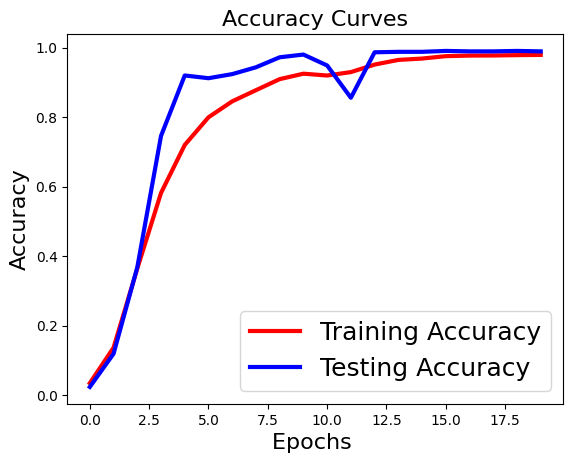

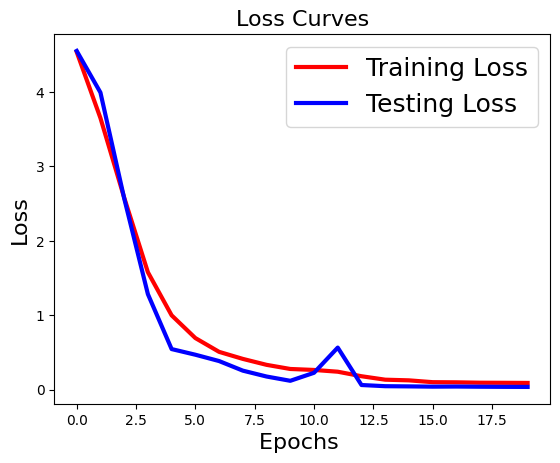

2022-12-11 12:01:30.878808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 36s 1s/step


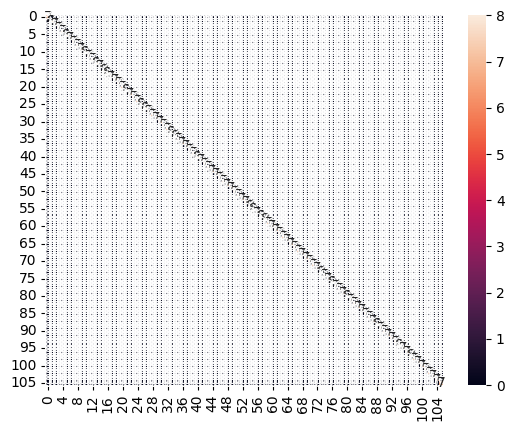

In [40]:
import tensorflow as tf
import numpy as np
import keras
#from tensorflow.python.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet121
from keras.backend import set_session
import cv2, os, gc
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pickle

class CNNClassifier:
    def __init__(self, shape=None, enableGPUTraining=True):
        if shape is None:
            self.resize = False
            self.imshape = (240, 320, 3)
        else:
            self.resize = True
            self.imshape = shape

        self.model = None
        self.x = list()
        self.y = list()
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.preds = None

        if enableGPUTraining:
            config = tf.compat.v1.ConfigProto()
            config.gpu_options.allow_growth = True
            config.log_device_placement = False
            sess = tf.compat.v1.Session(config=config)
            set_session(sess)
        else:
            os.environ["CUDA_VISIBLE_DEVICES"] = ""
   
    def init_model(self, num_classes):
        self.num_classes = num_classes
        base = DenseNet121(include_top=False, weights='imagenet', input_shape=self.imshape)
        for layer in base.layers[:5]:
            layer.trainable = False

        x = base.output
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(250, activation='relu')(x)
        x = keras.layers.Dropout(0.25)(x)
        preds = keras.layers.Dense(num_classes, activation='softmax', name='fcFinal')(x)

        self.model = keras.models.Model(base.input,preds)

        for layer in self.model.layers:
            layer.trainable = True
       
        return self.model

    def load_data(self, root_path, test_set_percent=0.20, limitedMemory=True):
        folder_names = sorted(os.listdir(root_path))
        for folder in folder_names:
            left = glob(os.path.join(root_path, folder, 'left', '*'))
            right = glob(os.path.join(root_path, folder, 'right', '*'))
            imPaths = left + right
            imPaths = [path for path in imPaths if '.bmp' in path]

            for imPath in imPaths:
                image = cv2.imread(imPath)
                if self.resize:
                    image = cv2.resize(image, self.imshape[:2], cv2.INTER_AREA)
                self.x.append(image)
                self.y.append(int(folder))
        self.y = keras.utils.np_utils.to_categorical(self.y)
        self.x = np.asarray(self.x)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=test_set_percent, stratify=self.y)
        self.X_train = (self.X_train / 255.).astype(np.float16)
        self.X_test = (self.X_test / 255.).astype(np.float16)

        return self.X_train, self.X_test, self.y_train, self.y_test

    def train(self, lr=0.001, epoch=20, batch_size=64, weights_path='./weights/'):

        if not os.path.exists(weights_path):
            os.makedirs(weights_path)

        callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_path, 'weights.h5'), \
            monitor='val_accuracy', verbose=0, save_weights_only=True, save_best_only=True)
        callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, verbose=1)
        callback_reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_lr=1e-7, patience=2, verbose=1)
        callbacks = [callback_checkpoint, callback_early_stopping, callback_reduce_lr]

        opt = tf.keras.optimizers.Adam(lr=lr)
        self.model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        history = self.model.fit(x=self.X_train, y=self.y_train, epochs=epoch, batch_size=batch_size, validation_data=(self.X_test, self.y_test), callbacks=callbacks)

        return self.model, history

    def predict(self, X=None, y=None, weights_path='./weights/'):
        if X is None and y is None:
            X = self.X_test
            y = self.y_test

        if len(X.shape) < 4:
            X = np.expand_dims(X, axis=0)
        self.model.load_weights(os.path.join(weights_path, 'weights.h5'))

        self.preds = self.model.predict(X, workers=0, use_multiprocessing=True)
        self.preds = np.argmax(self.preds, axis=1)
        loss = mean_squared_error(np.argmax(y, axis=1), self.preds)
        return self.preds, loss


    def generate_confusion_matrix(self, show_graph=True):
        matrix = confusion_matrix(np.argmax(self.y_test, axis=1), self.preds)
       
        if show_graph:
            df_cm = pd.DataFrame(matrix)
            sns.heatmap(df_cm, annot=True)
            plt.show()
        return matrix


def display_curve(train_vals, val_vals, datatype="Accuracy"):
    plt.plot(train_vals,'r',linewidth=3.0, label='Training '+datatype)
    plt.plot(val_vals,'b',linewidth=3.0, label='Testing '+datatype)
    plt.legend(fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel(datatype, fontsize=16)
    plt.title(datatype+' Curves', fontsize=16)
    plt.show()

def train(root_path):
    network = CNNClassifier()
    network.init_model(num_classes=107)
    network.load_data(root_path)
    model, history = network.train(lr=0.0001, batch_size=16)
    with open('model_history_densenet121.pkl', 'wb') as handle:
        pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)


def test(root_path):
    network = CNNClassifier()
    network.init_model(num_classes=107)
    network.load_data(root_path)
    with open('model_history_densenet121.pkl', 'rb') as handle:
        history = pickle.load(handle)
    display_curve(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')
    display_curve(history.history['loss'], history.history['val_loss'], 'Loss')
    preds, loss = network.predict()
    network.generate_confusion_matrix(show_graph=True)


if __name__ == '__main__':
    root_path = '/Users/avantikamahalingam/Desktop/Biometrics/Finger_Vein_Database'
    
    train(root_path)
    test(root_path)

## Xception Classifier with Fingervein recognition data

2022-12-12 01:54:06.908520: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-12 01:54:06.909726: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/homebrew/Caskroom/miniforge/base/envs/mlp1/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20


2022-12-12 01:54:24.641756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - ETA: 0s - loss: 3.8392 - accuracy: 0.1566

2022-12-12 01:58:44.977470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - 283s 1s/step - loss: 3.8392 - accuracy: 0.1566 - val_loss: 3.5757 - val_accuracy: 0.2709 - lr: 1.0000e-04
Epoch 2/20
191/191 [==============================] - 281s 1s/step - loss: 0.8234 - accuracy: 0.7769 - val_loss: 1.6437 - val_accuracy: 0.5746 - lr: 1.0000e-04
Epoch 3/20
191/191 [==============================] - 320s 2s/step - loss: 0.1636 - accuracy: 0.9541 - val_loss: 0.6600 - val_accuracy: 0.8181 - lr: 1.0000e-04
Epoch 4/20
191/191 [==============================] - 37652s 193s/step - loss: 0.0789 - accuracy: 0.9787 - val_loss: 0.3414 - val_accuracy: 0.9071 - lr: 1.0000e-04
Epoch 5/20
191/191 [==============================] - 460s 2s/step - loss: 0.0668 - accuracy: 0.9803 - val_loss: 0.1378 - val_accuracy: 0.9607 - lr: 1.0000e-04
Epoch 6/20
191/191 [==============================] - 410s 2s/step - loss: 0.0875 - accuracy: 0.9767 - val_loss: 0.2190 - val_accuracy: 0.9437 - lr: 1.0000e-04
Epoch 7/20
191/191 [===========================

INFO:tensorflow:Assets written to: ram://4fbf9d03-c6d8-42f0-8a10-b9ae6f800130/assets


INFO:tensorflow:Assets written to: ram://4fbf9d03-c6d8-42f0-8a10-b9ae6f800130/assets
2022-12-12 13:45:51.481671: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-12 13:45:51.490996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


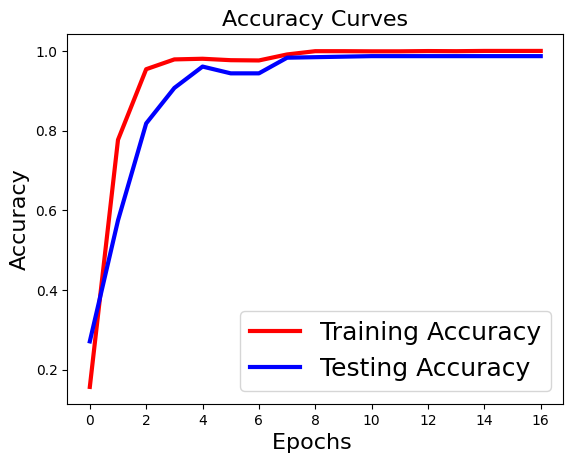

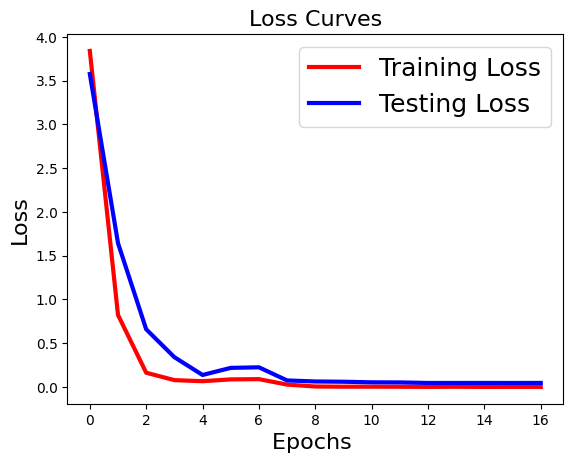

2022-12-12 13:46:09.394770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 19s 742ms/step


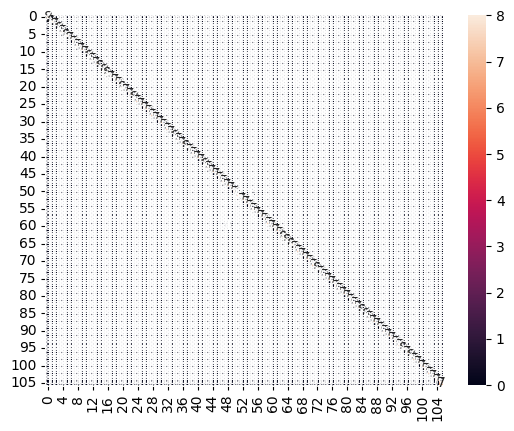

In [42]:
import tensorflow as tf
import numpy as np
import keras
#from tensorflow.python.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.backend import set_session
import cv2, os, gc
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pickle

class CNNClassifier:

    def __init__(self, shape=None, enableGPUTraining=True):
        if shape is None:
            self.resize = False
            self.imshape = (240, 320, 3)

        else:
            self.resize = True
            self.imshape = shape

        self.model = None
        self.x = list()
        self.y = list()
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.preds = None

        if enableGPUTraining:
            config = tf.compat.v1.ConfigProto()
            config.gpu_options.allow_growth = True
            config.log_device_placement = False
            sess = tf.compat.v1.Session(config=config)
            set_session(sess)
        else:
            os.environ["CUDA_VISIBLE_DEVICES"] = ""
   
    def init_model(self, num_classes):
        self.num_classes = num_classes
        base = Xception(include_top=False, weights='imagenet', input_shape=self.imshape)
        for layer in base.layers[:5]:
            layer.trainable = False

        x = base.output
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(250, activation='relu')(x)
        x = keras.layers.Dropout(0.25)(x)
        preds = keras.layers.Dense(num_classes, activation='softmax', name='fcFinal')(x)

        self.model = keras.models.Model(base.input,preds)
        for layer in self.model.layers:
            layer.trainable = True
       
        return self.model

    def load_data(self, root_path, test_set_percent=0.20, limitedMemory=True):
        folder_names = sorted(os.listdir(root_path))
        for folder in folder_names:
            left = glob(os.path.join(root_path, folder, 'left', '*'))
            right = glob(os.path.join(root_path, folder, 'right', '*'))
            imPaths = left + right
            imPaths = [path for path in imPaths if '.bmp' in path]

            for imPath in imPaths:
                image = cv2.imread(imPath)
                if self.resize:
                    image = cv2.resize(image, self.imshape[:2], cv2.INTER_AREA)
                self.x.append(image)
                self.y.append(int(folder))

        self.y = keras.utils.np_utils.to_categorical(self.y)
        self.x = np.asarray(self.x)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=test_set_percent, stratify=self.y)

        self.X_train = (self.X_train / 255.).astype(np.float16)
        self.X_test = (self.X_test / 255.).astype(np.float16)

        return self.X_train, self.X_test, self.y_train, self.y_test

    def train(self, lr=0.001, epoch=20, batch_size=64, weights_path='./weights/'):

        if not os.path.exists(weights_path):
            os.makedirs(weights_path)

        callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_path, 'weights.h5'), \
            monitor='val_accuracy', verbose=0, save_weights_only=True, save_best_only=True)
        callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, verbose=1)
        callback_reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_lr=1e-7, patience=2, verbose=1)
        callbacks = [callback_checkpoint, callback_early_stopping, callback_reduce_lr]

        opt = tf.keras.optimizers.Adam(lr=lr)
        self.model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        history = self.model.fit(x=self.X_train, y=self.y_train, epochs=epoch, batch_size=batch_size, validation_data=(self.X_test, self.y_test), callbacks=callbacks)

        return self.model, history

    def predict(self, X=None, y=None, weights_path='./weights/'):
        if X is None and y is None:
            X = self.X_test
            y = self.y_test

        if len(X.shape) < 4:
            X = np.expand_dims(X, axis=0)

        self.model.load_weights(os.path.join(weights_path, 'weights.h5'))

        self.preds = self.model.predict(X, workers=0, use_multiprocessing=True)
        self.preds = np.argmax(self.preds, axis=1)
        loss = mean_squared_error(np.argmax(y, axis=1), self.preds)
        return self.preds, loss


    def generate_confusion_matrix(self, show_graph=True):
        
        matrix = confusion_matrix(np.argmax(self.y_test, axis=1), self.preds)
        if show_graph:
            df_cm = pd.DataFrame(matrix)
            sns.heatmap(df_cm, annot=True)
            plt.show()
        return matrix


def display_curve(train_vals, val_vals, datatype="Accuracy"):
    plt.plot(train_vals,'r',linewidth=3.0, label='Training '+datatype)
    plt.plot(val_vals,'b',linewidth=3.0, label='Testing '+datatype)
    plt.legend(fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel(datatype, fontsize=16)
    plt.title(datatype+' Curves', fontsize=16)
    plt.show()

def train(root_path):
    network = CNNClassifier()
    network.init_model(num_classes=107)
    network.load_data(root_path)
    model, history = network.train(lr=0.0001, batch_size=16)
    with open('model_history_xception.pkl', 'wb') as handle:
        pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)


def test(root_path):
    network = CNNClassifier()
    network.init_model(num_classes=107)
    network.load_data(root_path)
    with open('model_history_xception.pkl', 'rb') as handle:
        history = pickle.load(handle)
    display_curve(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')
    display_curve(history.history['loss'], history.history['val_loss'], 'Loss')
    preds, loss = network.predict()
    network.generate_confusion_matrix(show_graph=True)


if __name__ == '__main__':
    root_path = '/Users/avantikamahalingam/Desktop/Biometrics/Finger_Vein_Database'

    train(root_path)
    test(root_path)